# Time Series SVR Algorithm

This algorithm is used to forecast FOREX prices for the EURUSD pair. It fetches data from MetaTrader5 and applies feature engineering to create additional data.

The forecasted values are set to:
- **Position 1** if the prediction indicates that the price will go up in the next hour
- **Position 0** if the prediction indicates that the price will go down in the nex hourx hour

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-darkgrid")
from matplotlib import cycler
import warnings
warnings.filterwarnings("ignore")
import ta
import seaborn as sns
import MetaTrader5 as mt5
from datetime import datetime
from UsefulFunctions import data, backtest

In [141]:
# Initiate bound between MetaTrader5 and Python
mt5.initialize()

True

In [143]:
# Fetching data from MetaTrader5 from 2015 to the present using the custom function "get_rates" from the data.py file
# The historical data retrieved is of 1-hour timeframe
df = data.get_rates("EURUSD", mt5.TIMEFRAME_H1, datetime(2015,1,1))
df.head()

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2015-01-02 08:00:00,1.2051,1.2057,1.2048,1.2054,134,20,0
2015-01-02 09:00:00,1.2053,1.2058,1.2034,1.2055,650,20,0
2015-01-02 10:00:00,1.2056,1.2069,1.2044,1.2047,871,20,0
2015-01-02 11:00:00,1.2048,1.2060,1.2038,1.2057,875,20,0
2015-01-02 12:00:00,1.2056,1.2056,1.2042,1.2050,441,20,0


In [145]:
# Drop columns spread and real_volume and remane columns tick_volumne to volumne
df = df[["open", "high", "low", "close", "tick_volume"]]
df.rename(columns={'tick_volume': 'volume'}, inplace=True)
df.head()

,open,high,low,close,volume
time,,,,,
2015-01-02 08:00:00,1.2051,1.2057,1.2048,1.2054,134
2015-01-02 09:00:00,1.2053,1.2058,1.2034,1.2055,650
2015-01-02 10:00:00,1.2056,1.2069,1.2044,1.2047,871
2015-01-02 11:00:00,1.2048,1.2060,1.2038,1.2057,875
2015-01-02 12:00:00,1.2056,1.2056,1.2042,1.2050,441


## Feature engineering 
**Creating new input variables from raw data**

In [148]:
# Create a second DataFrame from the close column and compute the percent change in a new column
df_copy = df[["close"]]
df_copy["pct_change"] = df_copy["close"].pct_change(1)
df_copy.head()

,close,pct_change
time,,
2015-01-02 08:00:00,1.2054,NaN
2015-01-02 09:00:00,1.2055,0.000083
2015-01-02 10:00:00,1.2047,-0.000664
2015-01-02 11:00:00,1.2057,0.000830
2015-01-02 12:00:00,1.2050,-0.000581


In [150]:
# New DataFrame with all indications from "ta" library and shifting them by one row
df_indicators = ta.add_all_ta_features(df, open="open", high="high", low="low", close="close", volume="volume", fillna=True).shift(1)
df_indicators.head()

,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
time,,,,,,,,,,,,,,,,,,,,,
2015-01-02 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02 09:00:00,1.2051,1.2057,1.2048,1.2054,134.0,44.666667,1.340000e+02,0.333333,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.205400,0.000000,0.000000,0.000000
2015-01-02 10:00:00,1.2053,1.2058,1.2034,1.2055,650.0,532.166667,7.840000e+02,0.678784,0.065000,-0.240000,...,0.000662,0.000132,0.000529,23.900744,4.780149,19.120596,1.205444,0.008296,0.008296,0.008296
2015-01-02 11:00:00,1.2056,1.2069,1.2044,1.2047,871.0,-129.793333,1.844674e+19,-0.078425,-0.043829,0.301378,...,-0.004122,-0.000718,-0.003403,40.437201,11.911559,28.525642,1.205129,-0.066363,-0.066385,-0.058072
2015-01-02 12:00:00,1.2048,1.2060,1.2038,1.2057,875.0,506.570303,7.880000e+02,0.200225,0.087433,-0.188571,...,-0.001204,-0.000816,-0.000389,47.232938,18.975835,28.257103,1.205374,0.083008,0.082974,0.024888


In [166]:
pd.set_option('display.max_columns', None)

In [168]:
# Here I concatenated both dataframes and drop the close column (which wasn't shifted) from df_copy
df_to_work = pd.concat((df_indicators, df_copy["pct_change"]), axis=1)
df_to_work.dropna(inplace=True)
df_to_work.head()

,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,pct_change
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02 09:00:00,1.2051,1.2057,1.2048,1.2054,134.0,44.666667,1.340000e+02,0.333333,0.000000,0.000000,0.000000,0.000000,1.205300,50.000000,1000.000000,1.205400,1.205400,1.205400,0.000000,0.000000,0.0,0.0,1.205300,1.206200,1.204400,0.149340,0.555556,0.0,0.0,1.2048,1.2057,1.20525,0.074664,0.666667,0.0,0.0,0.000000,0.000000,0.000000,1.205400,1.205400,1.205400,1.205400,0.000000,0.000000,0.000000,7.601558,1.000000,-0.085193,76.051414,76.051414,0.000000,1.20525,1.20525,1.20525,1.20525,0.0,0.0,0.0,0.0,0.000000,1.120249,1.120339,0.0,0.0,0.0,1.2044,1.2057,0.0,0.0,100.000000,0.0,0.0,0.0,0.000000,0.000000,66.666667,66.666667,-33.333333,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.205400,0.000000,0.000000,0.000000,0.000083
2015-01-02 10:00:00,1.2053,1.2058,1.2034,1.2055,650.0,532.166667,7.840000e+02,0.678784,0.065000,-0.240000,-0.240000,0.053924,1.204968,0.000000,1000.000000,1.205450,1.205550,1.205350,0.016591,0.750000,0.0,0.0,1.205100,1.206750,1.203450,0.273836,0.621212,0.0,0.0,1.2034,1.2058,1.20460,0.199096,0.875000,0.0,0.0,0.000008,0.000002,0.000006,1.205450,1.205450,1.205415,1.205407,0.011377,0.026168,-0.014791,0.000016,2.250000,-0.085243,76.096048,76.073731,0.022317,1.20460,1.20460,1.20460,1.20460,0.0,0.0,0.0,0.0,-66.666667,1.120249,1.120339,4.0,4.0,0.0,1.2044,1.2057,0.0,0.0,100.000000,0.0,0.0,0.0,100.000000,63.636364,87.500000,77.083333,-12.500000,0.0,0.0,0.000662,0.000132,0.000529,23.900744,4.780149,19.120596,1.205444,0.008296,0.008296,0.008296,-0.000664
2015-01-02 11:00:00,1.2056,1.2069,1.2044,1.2047,871.0,-129.793333,1.844674e+19,-0.078425,-0.043829,0.301378,0.030689,-0.524093,1.205160,57.273757,1000.000000,1.205200,1.205912,1.204488,0.118122,0.148780,0.0,0.0,1.205178,1.207111,1.203244,0.320838,0.376437,0.0,0.0,1.2034,1.2069,1.20515,0.290408,0.371429,0.0,0.0,-0.000050,-0.000009,-0.000041,1.205200,1.205200,1.205305,1.205355,0.049782,0.040932,0.008850,-0.000087,3.627358,-0.084993,75.872875,76.006779,-0.133904,1.20515,1.20515,1.20515,1.20515,0.0,0.0,0.0,0.0,56.000000,1.120249,1.120339,8.0,4.0,4.0,1.2044,1.2057,0.0,1.0,10.400000,0.0,0.0,0.0,83.673469,41.379310,37.142857,63.769841,-62.857143,0.0,0.0,-0.004122,-0.000718,-0.003403,40.437201,11.911559,28.525642,1.205129,-0.066363,-0.066385,-0.058072,0.000830
2015-01-02 12:00:00,1.2048,1.2060,1.2038,1.2057,875.0,506.570303,7.880000e+02,0.200225,0.087433,-0.188571,-0.042398,0.202228,1.205163,36.357636,1000.000000,1.205325,1.206078,1.204572,0.125000,0.748896,0.0,0.0,1.205175,1.207175,1.203175,0.331902,0.631250,0.0,0.0,1.2034,1.2069,1.20515,0.290378,0.657143,

## Machine Learning

In [264]:
# Splitting the data into features and labels for the ML model using a custom function "split_data" from data.py file
X = df_to_work.iloc[:,:-1]
y = df_to_work["pct_change"]

X_train, y_train, X_test, y_test = data.split_data(X, y)

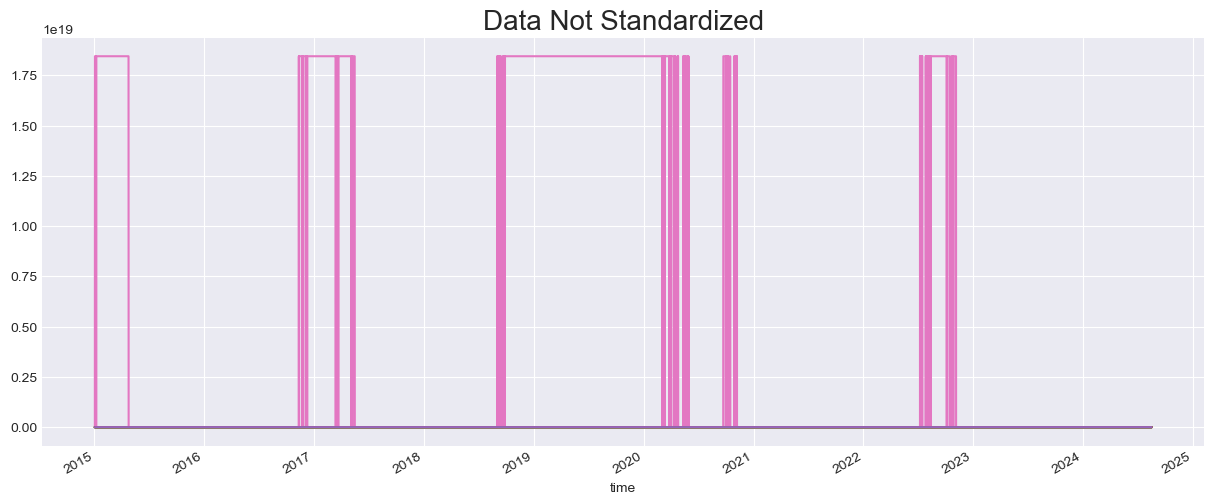

In [279]:
# Plotting features before standardization to visualize their unequal scales (plot shows only form the first 15 indicatos)
X.iloc[:,:15].plot(figsize=(15, 6))
plt.legend().set_visible(False)
plt.title("Data Not Standardized", fontsize=20)
plt.show()

### Standardizing The Data

In [269]:
from sklearn.preprocessing import StandardScaler

In [271]:
# Only the feature set (X) needs to be standardized, not the targets (labels)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

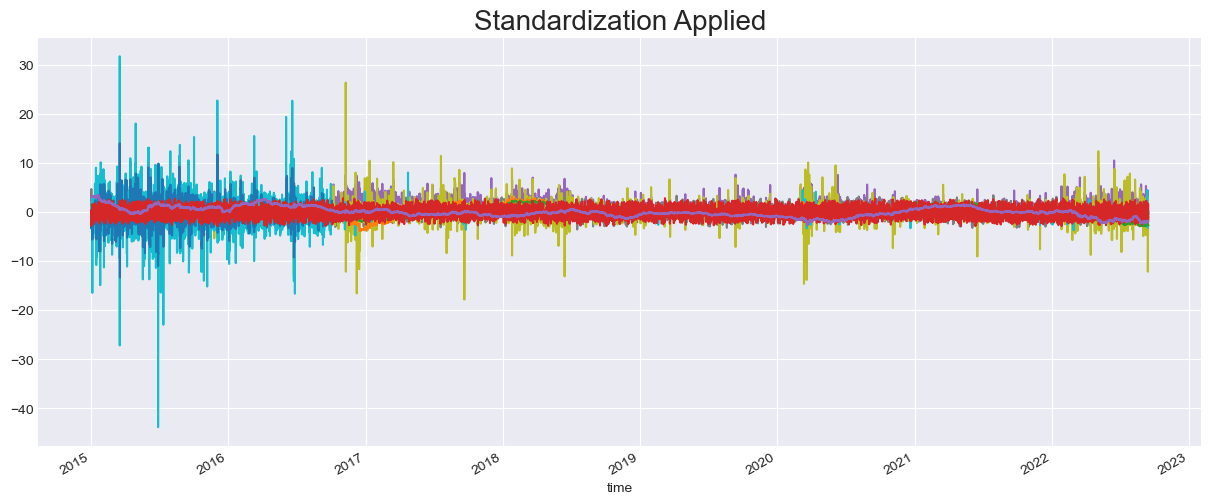

In [281]:
# Plotting the standardized data for the indicators (plot shows only form the first 15 indicatos)
pd.DataFrame(X_train_scaled, index=X_train.index, columns=X.columns).iloc[:,:15].plot(figsize=(15, 6))
plt.legend().set_visible(False)
plt.title("Standardization Applied", fontsize=20);